# Understanding gaussian processes

## Brief introduction

According to Wikipedia's entry on Gaussian Processes (GP): 

> a **Gaussian process** is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space

Now all that means is that it is a random process where all of the points are related to each other in a way that can be defined by a covariance matrix. What is nice about Gaussian processes is that they can be used to model functions without knowing exactly what their functional forms should be, so that estimates of functional value (and uncertainty!) can be made. 

If you are interested in a deeper dive into the theory behind GP's the go-to reference is Rasmussen & Williams "Gaussian Processes for Machine Learning" (which they provide free online [here](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)).

A briefer, beginner-friendly tutorial can also be found in Eric Schulz's ["A tutorial on Gaussian process regression: Modelling, exploring, and exploiting functions"](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf). This notebook is very largely based off of information found in this reference.

The point of this notebook is to go through the mathematics behind drawing random GP's instead of just calling a random package and having the results get shoved in front of me like I'm some sort of GP magician.

So, let us start, as always in Python, with importing the necessary packages.

In [1]:
# importing necessary packages
import numpy as np #for vector manipulation
from numpy.random import normal, seed, uniform #for drawing random values and setting the random seed
from scipy.optimize import minimize #for optimizing the log likelihood (in the later regression steps)
from scipy.special import gamma, kv #for matern kernel
import matplotlib.pyplot as plt #for plotting

# show plots in cells
%matplotlib inline 

# Setting a random seed so final results can be reproduced
seed(2)

## Choosing a kernel

Now that we have those, we need to define some kernel functions. The kernel function defines how correlated points are to each other based on their position. Or, in other words, gives a measure of the similarity between points. In all of the following, $\vec{\textbf{x}}$ is the domain vector of a single data point. These kernel functions are all evaluated many times to create the full covariance matrix.

The most basic kernels produce GPs of a familiar form. For example, creating a linear function.

Linear:
$$k_{L}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma_b^2\vec{\textbf{x}}^{T}\vec{\textbf{x}}^{\prime} + \sigma_a^2$$

Other, more useful kernels can replicate more complex behaviors. In all of the following, $\sigma$ descibes the amplitude of the GP while $\lambda$ describes the typical timescale (aka the length of the 'wiggles' in your function). Using $d$ as the distance between points, here are some common kernels.

$$d(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime}) = |\vec{\textbf{x}}-\vec{\textbf{x}}^{\prime}|$$

Radial Basis Function Kernel (Squared Exonential):
$$k_{RBF}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2 \exp\left(-\frac{d^2}{2 \lambda^2}\right)$$
Most common kernel function. Used for smoothly varying functions.

Ornstein–Uhlenbeck (Exponential):
$$k_{OU}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\exp\left(-\frac{d}{\lambda}\right)$$

Matern:
$$k_{Matern}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu} \ d}{\lambda}\right)^{\nu}K_{\nu}\left(\frac{\sqrt{2\nu} \ d}{\lambda}\right)$$
where $K_{\nu}$ is the modified Bessel function of order $\nu$ and $\Gamma(\nu)$ is the gamma function evaluated at $\nu$. Common values of $\nu$ are 3/2 and 5/2.

Periodic:
$$k_{P}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\exp\left(-\frac{2 \sin^2\left(\frac{\pi d}{P}\right)}{\lambda^2}\right)$$
Used for periodic functions.

Rational Quadratic:
$$k_{RQ}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\left(1+\frac{d^2}{2 \alpha \lambda^2}\right)^{-\alpha}, \alpha \ge 0$$
Used for functions with many timescales.

Technically, a valid kernel function has to be a "positive-definite function". While I won't go into what that actually means, I will say that when  positive-definite functions are added or multiplied together, they create more positive-definite functions, so any of the above kernels can be added or multiplied together to create more complicated kernels (see some examples in the defined kernel function).

If you want to learn more about kernels and how to choose them, you can read David Duvenaud's [Kernel Cookbook](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html)

In [2]:
# Linear kernel
def linear_kernel(hyperparameters, x1, x2):
    
    sigma_b, sigma_a = hyperparameters
    return sigma_b ** 2 * np.dot(x1, x2) + sigma_a ** 2


# Radial basis function kernel(aka squared exonential, ~gaussian)
def RBF_kernel(hyperparameters, dif_sq):
    
    kernel_amplitude, kernel_length = hyperparameters
    return kernel_amplitude ** 2* np.exp(-dif_sq / (2 * kernel_length ** 2))


# Ornstein–Uhlenbeck (Exponential) kernel
def OU_kernel(hyperparameters, dif):
    
    kernel_amplitude, kernel_length = hyperparameters
    return kernel_amplitude ** 2 * np.exp(-dif / kernel_length)


# Periodic kernel
def periodic_kernel(hyperparameters, dif):
    
    kernel_amplitude, kernel_length, kernel_period = hyperparameters
    return kernel_amplitude ** 2 * np.exp(-2 * np.sin(np.pi * dif / kernel_period) ** 2 / (kernel_length ** 2))


# Matern kernel (not sure if I implemented this correctly. Gets nans when dif==0)
def Matern_kernel(hyperparameters,dif,nu):
    
    kernel_amplitude, kernel_length = hyperparameters
    if dif == 0:
        return kernel_amplitude ** 2
    else:
        return kernel_amplitude ** 2 * ((2 ** (1 - nu)) / (gamma(nu))) * ((np.sqrt(2 * nu) * dif) / (kernel_length)) ** nu * kv(nu, (np.sqrt(2 * nu) * dif) / (kernel_length))


# Matern 3/2 kernel
def Matern32_kernel(hyperparameters, dif, nu):
    kernel_amplitude, kernel_length = hyperparameters

    return kernel_amplitude ** 2 * (1 + np.sqrt(3) * dif / kernel_length) * np.exp(-sqrt(3) * dif / kernel_length)


# Matern 5/2 kernel
def Matern52_kernel(hyperparameters, dif, nu):
    kernel_amplitude, kernel_length = hyperparameters

    return kernel_amplitude ^ 2 * (1 + np.sqrt(5) * dif / kernel_length + 5 * dif ^ 2 / (3 * kernel_length ^ 2)) * np.exp(-sqrt(5) * dif / kernel_length)


# Rational Quadratic kernel (equivalent to adding together many SE kernels 
# with different lengthscales. When α→∞, the RQ is identical to the SE.)
def RQ_kernel(hyperparameters, dif_sq):
    
    kernel_amplitude, kernel_length, alpha = hyperparameters
    alpha = max(alpha, 0)
    return kernel_amplitude** 2 * (1 + dif_sq / (2 * alpha * kernel_length ** 2)) ** -alpha


# reating a custom kernel (possibly by adding and multiplying other kernels?)
def kernel(hyperparameters, x1, x2):
        
    # converting inputs to arrays and finding their squared differences
    x1a = np.array(x1)
    x2a = np.array(x2)
    dif_vec = x1a - x2a
    dif_sq = np.dot(dif_vec, dif_vec)
    dif = np.sqrt(dif_sq)
    
    # final = RBF_kernel(hyperparameters, dif_sq) 
    # final = OU_kernel(hyperparameters, dif) 
    # final = linear_kernel(hyperparameters, x1a, x2a)
    final = periodic_kernel(hyperparameters, dif)
    # final = RQ_kernel(hyperparameters, dif_sq)
    # final = Matern_kernel(hyperparameters, dif, 3/2) #doesn't seem to be working right now
    
    # example of adding kernels
    # final = periodic_kernel(hyperparameters[0:3], dif) + RBF_kernel(hyperparameters[3:5], dif_sq)
    
    # example of multiplying kernels
    # final = periodic_kernel(hyperparameters[0:3], dif) * RBF_kernel(hyperparameters[3:5], dif_sq)

    return final

## Creating a covariance matrix

Now that we've chosen (or constructed) our kernel, we have to use it to calculate how similar each of the points are to each other. Python is not always the most elegant, so I created a function to do this with two for loops.

In [3]:
# Creates the covariance matrix by evaluating the kernel function for each pair of passed inputs
# You could exploit symmetry or equal point spacing for more efficient calculation and storage
def covariance(x1list,x2list,hyperparameters):
    K=np.zeros((len(x1list),len(x2list)))
    for i, x1 in enumerate(x1list):
        for j, x2 in enumerate(x2list):
            K[i,j]=kernel(hyperparameters,x1,x2)
    return K

Now lets try out some values for our hyperparameters and calculate the covariance matrix for throughout the input domain!

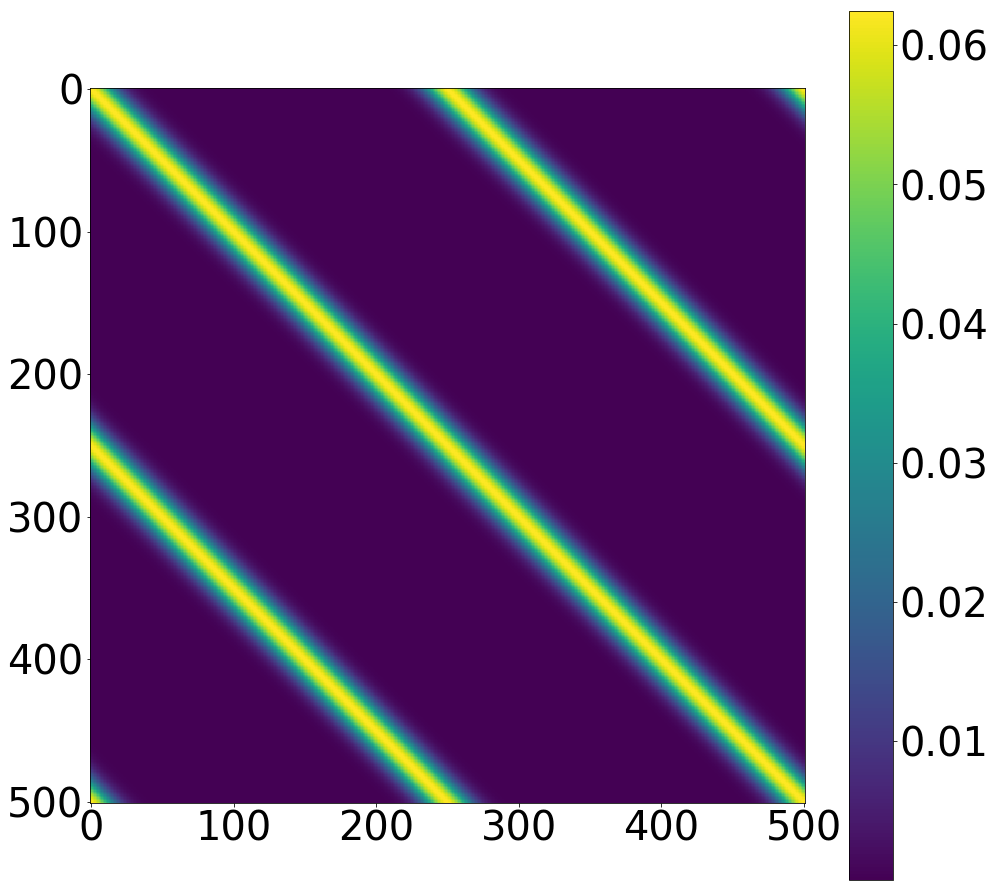

In [22]:
# kernel hyper parameters (AFFECTS SHAPE OF GP's, make sure you have the right amount!)
# just some starting values, see each kernel for what these mean
# hyperparameters = [0.8, 0.3, 2 ,0.5, .3]
hyperparameters = [0.25, 0.3, 4] 

# how finely to sample the domain
GP_sample_amount = 500 + 1

# creating many inputs to sample the eventual gaussian process on
domain = 8 #how wide the measurement domain is
x_samp = np.linspace(0, domain, GP_sample_amount)

# Finding how correlated the sampled inputs are to each other
# (aka getting the covariance matrix by evaluating the kernel function at all pairs of points)
K_samp = covariance(x_samp, x_samp, hyperparameters)


# initialize nice big plots with large fonts
# wide changes the aspect ratio of the plot
def initalize_plot(wide=1):
    fig = plt.figure(figsize=(wide * 16, 16))
    ax = plt.subplot(111)  # allows the fonts to be easily modified
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(40)
    return ax
        

# plot a heatmap of passed covariance matrix (colors show how correlated points are to each other)
# save is a string ending in ".png" that specifies the filename to save the figure to
def plot_K(K, save=""):
    
    initalize_plot()
    
    # plot the heatmap
    plt.imshow(K)
    
    # add a colorbar with large fonts
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=40) 
    
    fig = plt.gcf()
    if save != "":
        fig.savefig(save, bbox_inches="tight")

        
plot_K(K_samp, save="prior_covariance.png")

## "Square-rooting" the covariance matrix (Cholesky decomposition)

In order to accurately draw some sample curves for our GP, we actually need to calculate the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of our covariance matrix. The Cholesky decomposition is finding the matrix $L$ such that:

$$K = L * L^{T}$$

This can only be done on positive-definite matrices, which is already a requirement for a valid covariance matrix

In [5]:
# Calculating the Cholesky decomposition (https://en.wikipedia.org/wiki/Cholesky_decomposition)
# Kind of like the square root of the matrix. K = L * transpose(L)
# This operation can only be performed on positive definite matrices, which all covariance matrices are supposed to be
# the small identity term ensures that the algorithm is numerically stable
L_samp = np.linalg.cholesky(K_samp + 1e-10 * np.eye(GP_sample_amount))

## Drawing our first processes

Okay, we have the "square-root" of our covariance matrix and are finally ready to draw some sweet sweet random squiggly lines. 

The covariance matrix shows the multivariate Gaussian relationship between all of the points in the domain, so what we have to do to get some random GP curves is draw GP_sample_amount values from the normal distribution and multiply that by the calculated "square-root" of our covariance matrix.

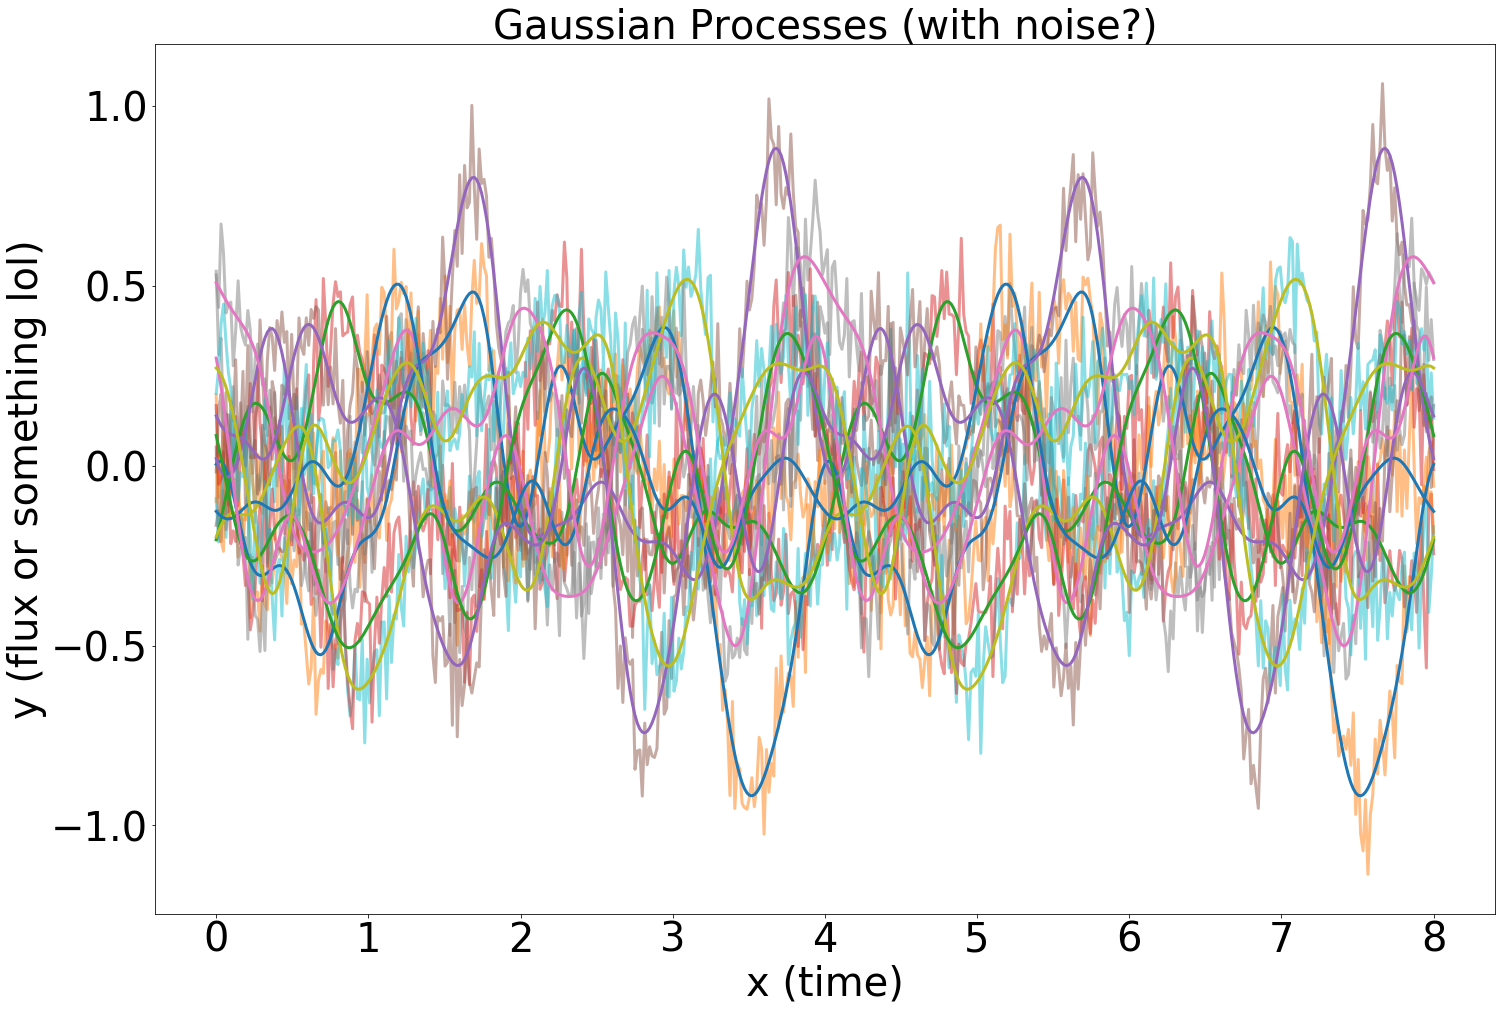

In [23]:
#noise to add to gaussians (to simulate observations)
GP_noise = .1

#how many GPs to plot
amount_of_GPs = 10

#plotting amount_of_GPs randomly drawn Gaussian processes using the kernel function to correlate points
ax = initalize_plot(wide=1.5)
for i in range(amount_of_GPs):
    
    #sampled possible GP function values
    GP_func = np.matmul(L_samp, normal(size=GP_sample_amount)) 
    plt.plot(x_samp, GP_func, zorder=2, linewidth=3)
    
    #sampled possible GP observations (that have noise)
    GP_obs = GP_func + GP_noise * normal(size=GP_sample_amount) 
    plt.plot(x_samp, GP_obs, alpha=0.5, zorder=1, linewidth=3)

# setting plot labels
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
ax.set_title("Gaussian Processes (with noise?)", fontsize=40)

# showing and saving the plot
fig = plt.gcf()
fig.savefig("random_draws.png", bbox_inches="tight")

# MAGIC!!!

I still haven't gotten over that you can create infinitely many weird squiggles of a characteristic shape yet.

## Conditioning our model with data

We've created some squiggles, but now we want to see which squiggles make sense with the "data" we have. So let's create some data and see if we can make the squiggles comply.

I've written a sample function to generate observed data (currently a noisy sine function) already. Now we can just specify the amount of measurements and the noise that goes along with them and we can go from there.

In [7]:
# "true" underlying function for the fake observations
def observations(x, measurement_noise):
    
    # a phase shifted sine curve with noise
    shift = uniform(high=2 * np.pi)
    return np.sin(np.pi / 2 * x + shift) + np.multiply(np.square(measurement_noise), normal(size=len(x)))


# creating observations to test methods on
amount_of_measurements = 25

# Uncertainty in the data (AFFECTS SPREAD OF DATA AND HOW TIGHTLY THE GP's WILL TRY TO HUG THE DATA)
# aka how much noise is added to measurements and measurement covariance function
# can be a list (length=amount_of_measurements) or single number
measurement_noise = 0.3

# make measurement noise into an array (for my convenience)
measurement_noise = np.ndarray.flatten(np.array([measurement_noise]))
if len(measurement_noise) == 1:
    measurement_noise = np.ones(amount_of_measurements) * measurement_noise[0]

x_obs = uniform(high=domain, size=amount_of_measurements)  # observation inputs
y_obs = observations(x_obs, measurement_noise)  # observation outputs

We have our data, now lets see how good these GPs look!!!

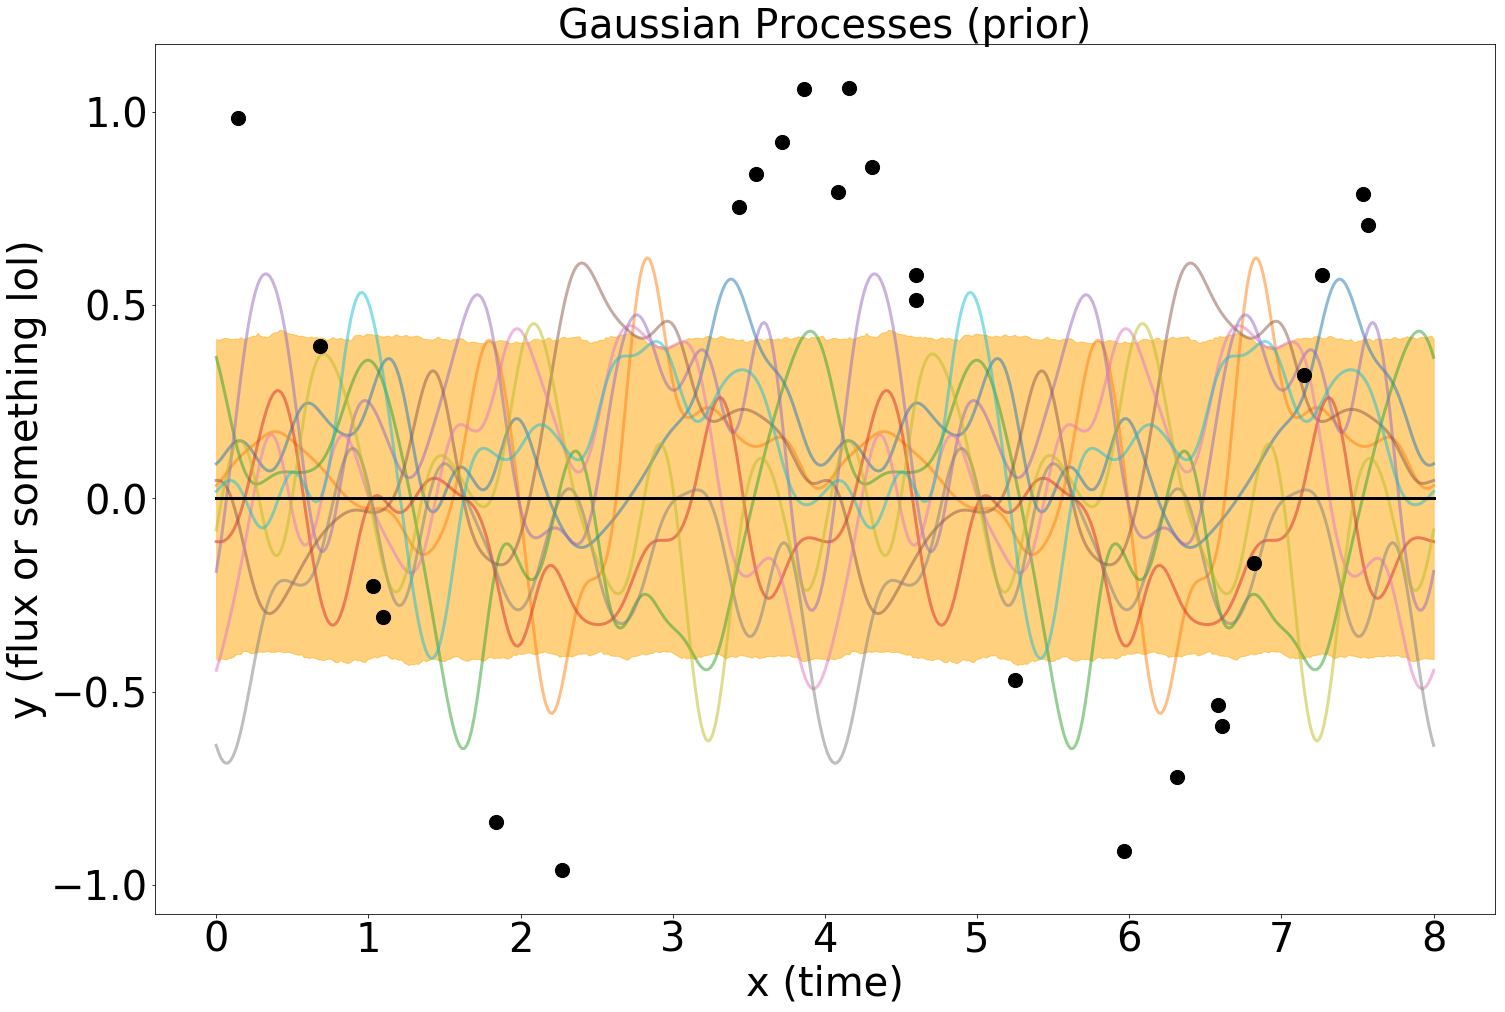

<Figure size 432x288 with 0 Axes>

In [8]:
# creating a plotting template that shows the data, some GP draws, and a prediction interval.
def custom_plot(x_samp, L, x_obs, y_obs, title="Gaussian Processes", mean_post=np.zeros(len(x_samp)), draws=5000, save=""):
    
    ax = initalize_plot(wide=1.5)
    
    # drawing lots of GPs (to get a good estimate of 5-95th percentile.
    # There is an analytical way to do it (see eq. 2.26 of Rasmussen & Williams "Gaussian Processes for Machine Learning")
    storage = np.zeros((draws, GP_sample_amount))
    for i in range(draws):
        storage[i, :] = np.matmul(L, normal(size=GP_sample_amount)) + mean_post

    # how many curves to show
    show = 10
    for i in range(show):
        plt.plot(x_samp, storage[i, :], alpha=0.5, zorder=1, linewidth=3)
        
    # filling the 5-95th percentile with a transparent orange
    storage = np.sort(storage, axis=0)
    plt.plot(x_samp,mean_post, color="black", zorder=2, linewidth=3)
    plt.fill_between(x_samp, storage[int(0.95 * draws), :], storage[int(0.05 * draws), :], alpha=0.5, color='orange')

    # plotting "observations"
    plt.scatter(x_obs, y_obs, color="black", zorder=2, s=200)
    
    # plot labels
    plt.xlabel("x (time)")
    plt.ylabel("y (flux or something lol)")
    ax.set_title(title, fontsize=40)
    
    fig = plt.gcf()
    
    # save the plot if the user specifies somewhere to save it
    if save != "":
        fig.savefig(save, bbox_inches="tight")


# creating our custom plot
custom_plot(x_samp, L_samp, x_obs, y_obs, title="Gaussian Processes (prior)", save="prior.png")

Hmmmm well they don't look so good yet, but we haven't used our data yet to find the conditional distribution of funtion values yet. This process is a little opaque and takes a long time staring at equations and doing linear algebra, but for this tutorial we are just going to look at and calculate examples of the results which are shown in pages 13-15 of [Eric Schulz's tutorial](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf). The following cell calculates the mean function and covariance for the posterior GP.

An interesting thing to note is that the measured values of obsrevations solely affect the posterior mean. The posterior covariance matrix is affected by the spacings and uncertainties of the data points. When there are more data points close together, the subtracted value in the posterior covariance calculation is higher, so the variance is smaller there because you know the function better there. The brighter yellow spots in the covariance image correspond to the regions where the prediction interval is large.

## A note on matrix inversions
The calculations used in GP regression often call for the use of matrix inversions. Explicit matrix inversion is often numerically unstable and not the most efficient. It can be replaced for our uses with left matrix division. Left matrix divisions are used as a computationally stable alternative to explicitly calculating the inverses of matrices that may have small determinants. Left matrix division is defined such that  $x = A\backslash B$ gives $x$ that solves $A*x = B$. With some rearranging, it can be shown that  $x = A \backslash B=A^{-1}B$. See the commented lines below to see equivalent calculations.

The command for left matrix dividing in python is numpy.linalg.lstsq()

In [9]:
def GP_posteriors(x_obs, x_samp, measurement_noise, hyperparameters):
    
    #creating all covariance matrices (as defined on pages 13-15 of Eric Schulz's tutorial)
    K_samp = covariance(x_samp, x_samp, hyperparameters)
    noise_I = np.square(measurement_noise) * np.identity(amount_of_measurements)
    K_obs = covariance(x_obs, x_obs, hyperparameters) + noise_I
    K_samp_obs = covariance(x_samp, x_obs, hyperparameters) 
    K_obs_samp = covariance(x_obs, x_samp, hyperparameters)

    # inv_K_obs = np.linalg.inv(K_obs)

    # mean of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
    # mean_post = np.matmul(K_samp_obs, np.matmul(inv_K_obs, y_obs))
    mean_post = np.matmul(K_samp_obs, np.linalg.lstsq(K_obs, y_obs)[0])
    
    # covariance matrix of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
    # K_post = K_samp - np.matmul(K_samp_obs, np.matmul(inv_K_obs, K_obs_samp))
    K_post = K_samp - np.matmul(K_samp_obs, np.linalg.lstsq(K_obs, K_obs_samp)[0])
    L_post = np.linalg.cholesky(K_post + 1e-10 * np.eye(GP_sample_amount))
    
    return mean_post, K_post, L_post


mean_post, K_post, L_post = GP_posteriors(x_obs, x_samp, measurement_noise, hyperparameters)

C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


With the linear algebra out of the way, lets plot the new covariance and mean function! 
Spoiler alert: it's way better.

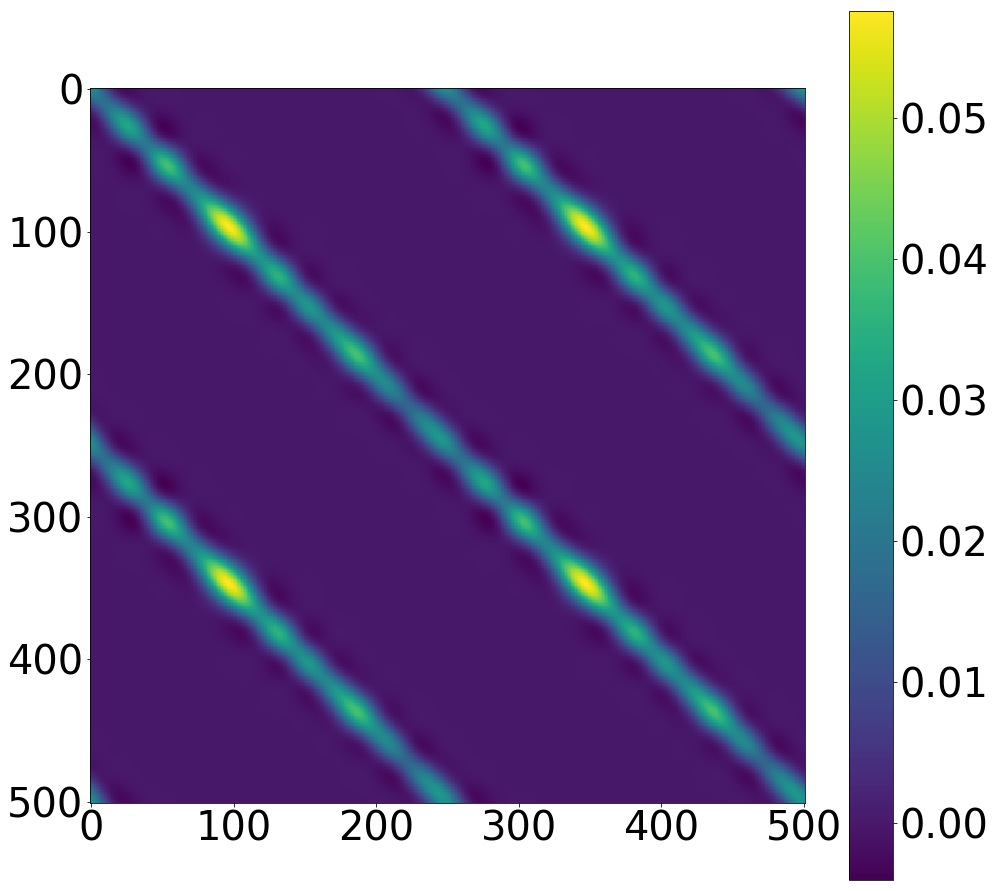

<Figure size 432x288 with 0 Axes>

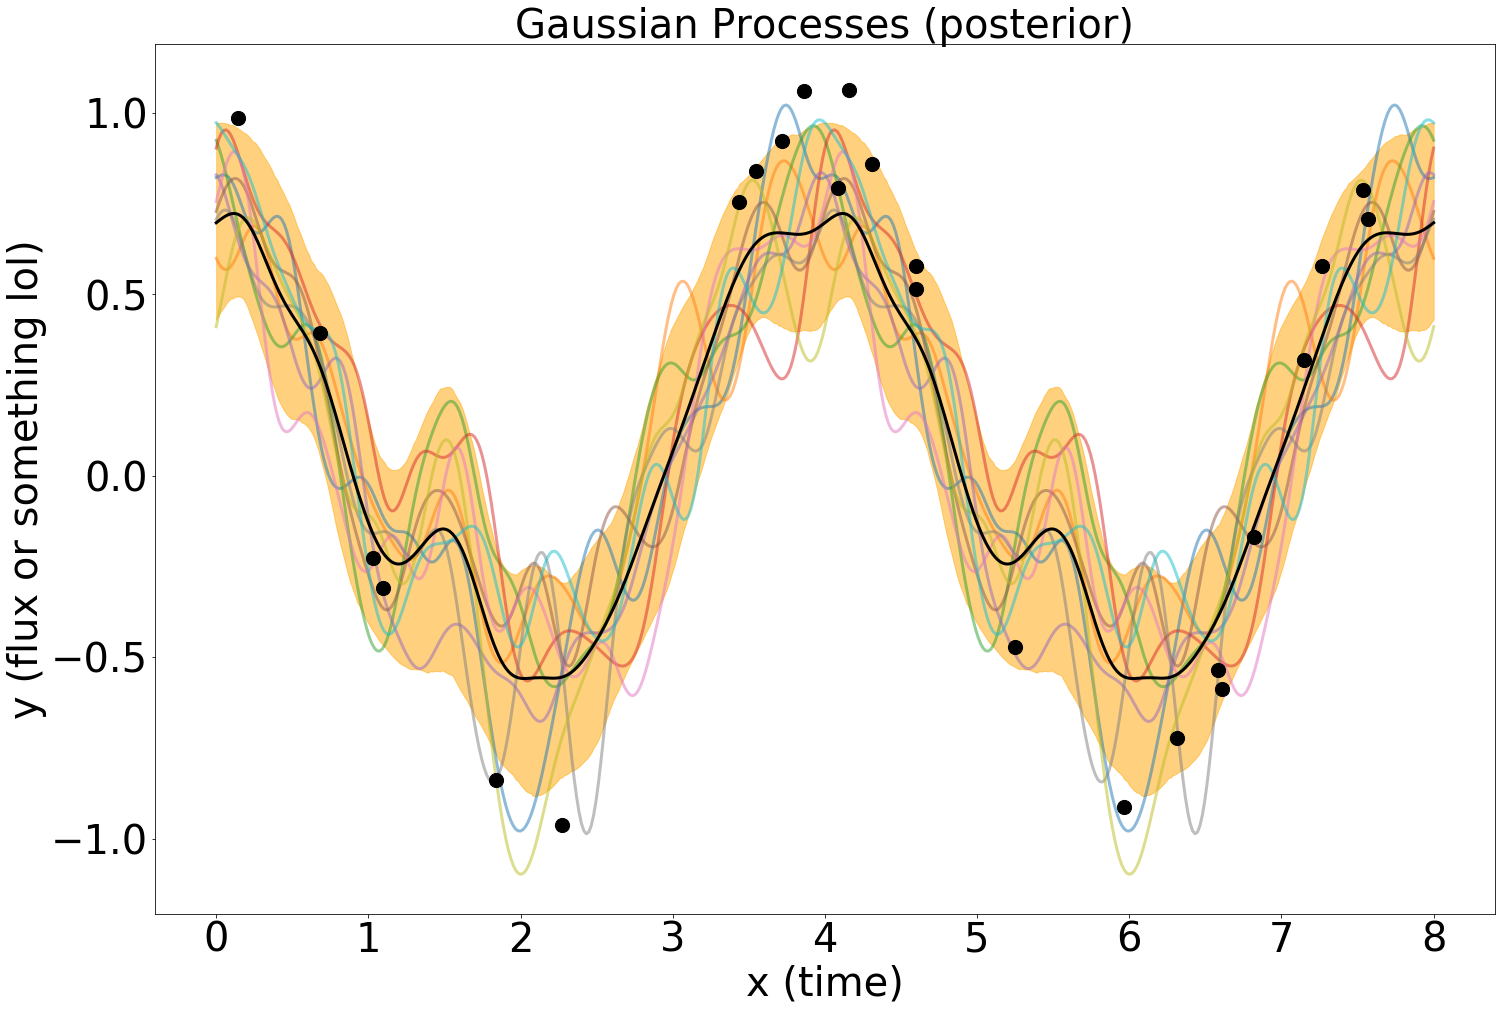

<Figure size 432x288 with 0 Axes>

In [10]:
# plot the posterior covariance matrix (colors show how correlated points are to each other)
plot_K(K_post, save="posterior_covariance")

# plotting randomly drawn Gaussian processes with the mean function and covariance of the posterior
# much closer to the data, no?
custom_plot(x_samp, L_post, x_obs, y_obs, mean_post=mean_post, title="Gaussian Processes (posterior)",  save="posterior.png")

## Choosing hyperparameters

So we just showed how to condition a GP with a specific kernel and set of hyperparameters with observed data, but how does one find the best hyperparameters?

from [Eric Schulz's tutorial](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf):

> As the posterior distribution over the hyper-parameters is non-trivial to obtain, full Bayesian inference of the hyper-parameters is not frequently used in practice. Instead, common practice is to obtain point estimates of the hyper-parameters by maximising the marginal (log) likelihood.

The worst part of any maximum likelihood estimation is usually finding and writing down the likelihood. Luckily, someone else has done it for us. The log marginal likelihood of the outputted measurements given the measurment inputs and hyperparameters is as follows (as seen on page 19):

$$\log p(\textbf{y}|\textbf{X},\boldsymbol{\theta})=-\frac{1}{2} \textbf{y}^T \textbf{K}_y^{-1} \textbf{y} -\frac{1}{2} \log|\textbf{K}_y| - \frac{n}{2} \log (2 \pi)$$

to paraphrase the tutorial

>$\textbf{K}_y$ is the covariance matrix of the noisy output values. The marginal log likelihood can be viewed as a penalized fit measure, where $-\frac{1}{2} \textbf{y}^T \textbf{K}_y^{-1} \textbf{y}$ measures the data fit, $-\frac{1}{2} \log|\textbf{K}_y|$ is a complexity penalization term, and $- \frac{n}{2} \log (2 \pi)$ is a normalization constant.

Or, using our note on matrix inversions:

$$\log p(\textbf{y}|\textbf{X},\boldsymbol{\theta})=-\frac{1}{2} \textbf{y}^T \textbf{K}_y \backslash \textbf{y} -\frac{1}{2} \log|\textbf{K}_y| - \frac{n}{2} \log (2 \pi)$$

This is normally optimized numerically, here done with scipy's minimize function. Hopefully our "Optimization terminates successfully."

In [11]:
# negative log likelihood of the data given the current kernel parameters (as seen on page 19)
# (negative because scipy has a minimizer instead of a maximizer)
def nlogL(hyperparameters):
    n = len(y_obs)
    
    noise_I = np.square(measurement_noise) * np.identity(amount_of_measurements)
    K_obs = covariance(x_obs, x_obs, hyperparameters) + noise_I
    
    # goodness of fit term
    # data_fit = -1 / 2 * np.matmul(np.transpose(y_obs), np.matmul(np.linalg.inv(K_obs), y_obs))
    data_fit = -1 / 2 * np.matmul(np.transpose(y_obs), np.linalg.lstsq(K_obs, y_obs)[0])
    # complexity penalization term
    penalty = -1 / 2 * np.log(np.linalg.det(K_obs))
    # normalization term (functionally useless)
    normalization = -n / 2 * np.log(2 * np.pi)
    
    return -1 * (data_fit + penalty + normalization)


# numerically maximize the likelihood to find the best hyperparameters
result = minimize(nlogL, hyperparameters)
# print(result) #uncomment this for more details
print(result.message)

C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.


Finally we've found "optimal" hyperparameters. Let's plot the new conditioned mean function and see what it looks like.

'Best-fit' hyperparameters
[1.45571506 2.83979713 4.02445851]


C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


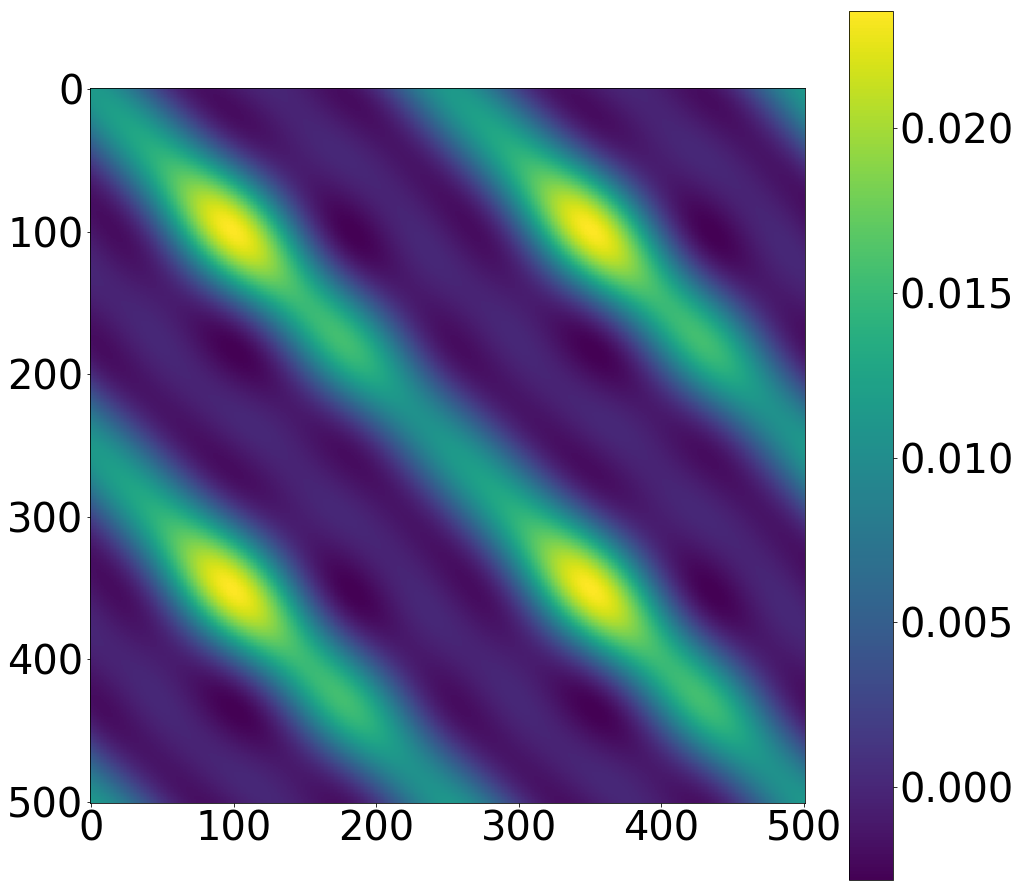

<Figure size 432x288 with 0 Axes>

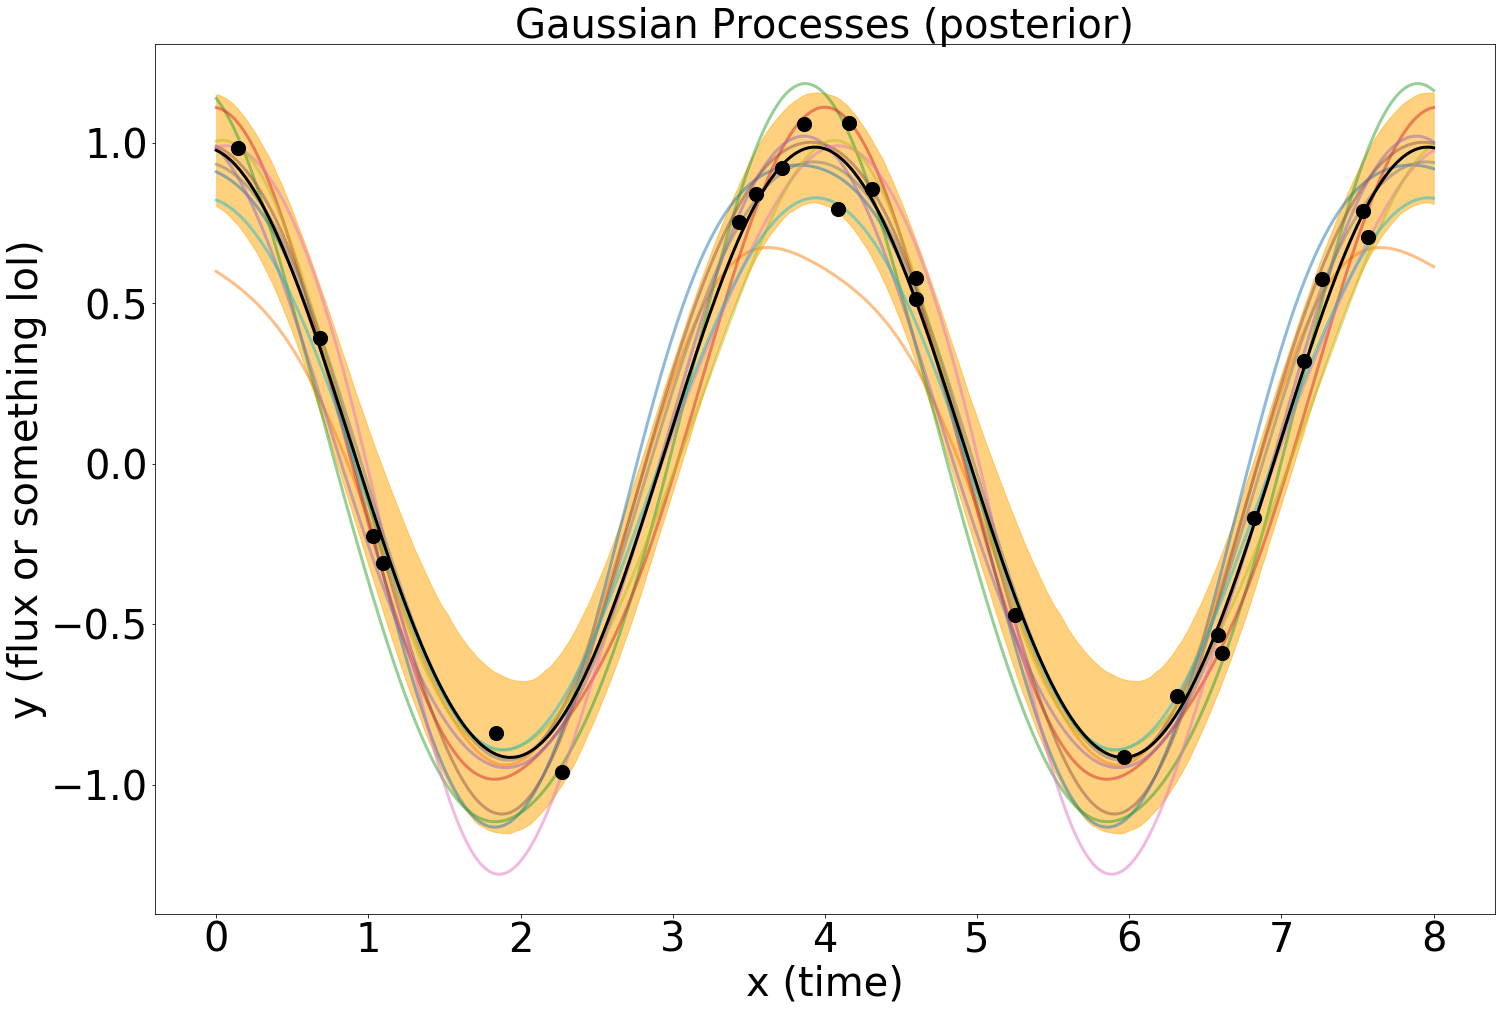

<Figure size 432x288 with 0 Axes>

In [12]:
# reruning analysis of posterior with the "most likely" kernel amplitude and lengthscale
hyperparameters = result.x

print("'Best-fit' hyperparameters")
print(hyperparameters)

mean_post, K_post, L_post = GP_posteriors(x_obs, x_samp, measurement_noise, hyperparameters)

# plot the posterior covariance of the "most likely" posterior matrix 
# (colors show how correlated points are to each other)
plot_K(K_post, save = "final_posterior_covariance.png")

# plotting randomly drawn Gaussian processes with the mean function and covariance of the posterior
# much closer to the data, no?
custom_plot(x_samp, L_post, x_obs, y_obs, mean_post=mean_post, title="Gaussian Processes (posterior)", save = "final_posterior.png")

Looks pretty good.

Hope this helped you figure out a bit about GPs!